This is a rough notebook to try out various code to learn stuff

In [1]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

In [2]:
print(qiskit.__version__)

1.3.1


Statevector([0.5      +0.j, 0.8660254+0.j],
            dims=(2,))


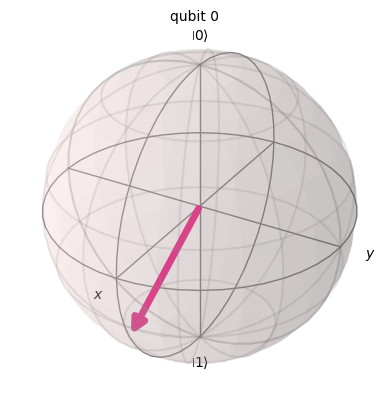

In [3]:
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

circ = QuantumCircuit(1)
circ.u(np.pi/1.5,0,0,0)

state = Statevector.from_instruction(circ)
print(state)
plot_bloch_multivector(state)

In [4]:
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_histogram
import numpy as np

qc = QuantumCircuit(1,1)
qc.x(0)
qc1 = qc.copy()
qc.measure(0,0)
print(qc.draw())
simulator = AerSimulator(method='statevector')  # Use statevector simulator
result = simulator.run(qc, shots = 100).result()
counts = result.get_counts(qc)
plot_histogram(counts)
qc = qc1.copy()
print(qc.draw())

# Simulate to confirm the initialization



     ┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 
     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          


Counts without measurement in between: {'00': 521, '11': 503}
Counts with measurement in between: {'11': 518, '00': 506}


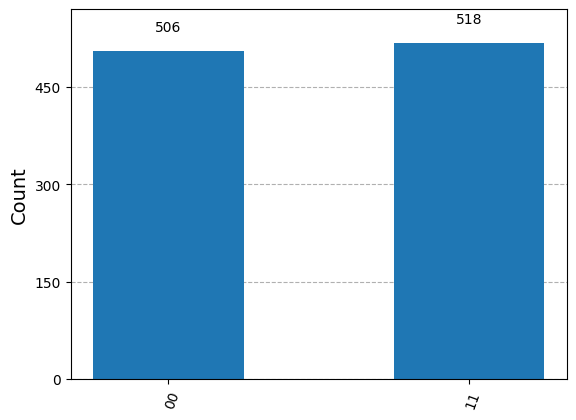

In [5]:
from qiskit.visualization import plot_histogram

# Create a quantum circuit
qc1 = QuantumCircuit(2, 2)

# Apply a Hadamard gate to qubit 0
qc1.h(0)

# Apply a CNOT gate with qubit 0 as control and qubit 1 as target
qc1.cx(0, 1)

# Measure both qubits
qc1.measure([0, 1], [0, 1])

# Simulate
simulator = AerSimulator(method='statevector')  # Use statevector simulator
result1 = simulator.run(qc1, shots = 1024).result()
counts1 = result1.get_counts(qc1)

# Display the results
print("Counts without measurement in between:", counts1)
plot_histogram(counts1)


# Create a quantum circuit
qc2 = QuantumCircuit(2, 2)

# Apply a Hadamard gate to qubit 0
qc2.h(0)

# Measure qubit 0
qc2.measure(0, 0)

# Reapply a CNOT gate (note that qubit 0 is now collapsed)
qc2.cx(0, 1)

# Measure both qubits
qc2.measure([0, 1], [0, 1])

# Simulate
result2 = simulator.run(qc1, shots = 1024).result()
counts2 = result2.get_counts(qc1)

# Display the results
print("Counts with measurement in between:", counts2)
plot_histogram(counts2)


In [11]:
from qiskit import *
import numpy as np
from qiskit.circuit.library import UnitaryGate

gamma = 1.52*10**9
total_time = 1000*10**(-12)
delta_t = 10*10**(-12)
n_steps = int(total_time/delta_t)

M_0 = np.array([[1, 0], [0, np.exp(-gamma * delta_t)]])
M_1 = np.array([[0, np.sqrt(1 - np.exp(-gamma * delta_t))], [0, 0]])

M_0_dag = M_0.conj().T
M_1_dag = M_1.conj().T

I = np.eye(2)

D_M_0 = np.array([[0, 0], [0, np.sqrt(1 - np.exp(-gamma * delta_t))]])
D_M_1 = np.array([[1, 0], [0, np.exp(-gamma * delta_t)]])

D_Mdag_0 = np.array([[0, 0], [0, np.sqrt(1 - np.exp(-gamma * delta_t))]])
D_Mdag_1 = np.array([[1, 0], [0, np.exp(-gamma * delta_t)]])


# 1-dilations of the Kraus operators (non-unitary)

U_M_0 = np.block([[M_0, D_Mdag_0], [D_M_0, -M_0_dag]])
U_M_1 = np.block([[M_1, D_Mdag_1], [D_M_1, -M_1_dag]])

#  ---------------------------------------------------------------------

#defining the initial density matrix rho
rho = np.zeros((2,2),'complex') 
rho[0,0]=1/4
rho[0,1]=1/4
rho[1,0]=1/4
rho[1,1]=3/4
gamma=1.52e9# gamma is the spontaneous emission rate

iden=np.eye(2)

#flattening or vectorize the density matrix
rho_norm=sp.norm(rho)
rho_flat= rho.flatten()/rho_norm
#defining the Kraus operators
def k_0(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k

#defining the function for dilation
def udil(k):
#first and second stands for the M and N, i.e. Kraus and its complex conjugate   
    first= k
    kc=k.conjugate()  #complex conjugate of k
    second= kc
    fcon = (first.conjugate()).T
    scon = (second.conjugate()).T
    #calculate the defect operators of each Kraus operators
    fdef = sp.sqrtm(iden-np.dot(fcon,first))
    sdef = sp.sqrtm(iden -np.dot(scon,second))
    fcondef = sp.sqrtm(iden-np.dot(first,fcon))
    scondef = sp.sqrtm(iden-np.dot(second,scon))
    #1-dilation process 
    Ufirst= np.block([[first, fcondef], [fdef,-fcon]])

    Usecond=np.block([[second, scondef], [sdef,-scon]])

    ufre=np.reshape(Ufirst,(1,16))
    usec=np.reshape(Usecond,(1,16))
    #returning the unitaries for both the Kraus operator and its complex conjugate
    return ufre,usec 

rho_at_t=np.zeros((1000,2), "complex")
time=np.zeros((1000,1),)
udil01=np.zeros((1000,16),"complex")
udil02=np.zeros((1000,16),"complex")
udil11=np.zeros((1000,16),"complex")
udil12=np.zeros((1000,16),"complex")
# assigning the time-steps
for t in range(0,1000):
    tt=t*10**-12
    k0=k_0(tt)
    k1=k_1(tt)
    udil01[t],udil02[t] = udil(k0)    
    udil11[t],udil12[t] = udil(k1)

shots = 2000
#create dictionaries to store the results. three binary digits due to 8*8 matrix needs three qubits
result = {'00': 0, '01': 0, '10': 0, '11': 0}
result2 = {'00': 0, '01': 0, '10': 0, '11': 0} 
p_excited = []# create list to store probability for acceptor state
p_ground = []# create list to store probability for donor state

# Below are the loop of the QASM simulation 
aersim=AerSimulator()

#for Kraus operator 1
U1first=np.reshape(udil01[0],(4,4))
# qiskit quantum circuit generation process
initial_state = rho_flat
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.initialize(initial_state, qr)
# generating self-defined quantum gates with dilated unitaries
A = Operator(U1first)
U_G_op = A
qc.unitary(U_G_op, qr)

print("Original Circuit:")
print(qc.draw())

decomposed_circuit = qc.decompose()
print("\nDecomposed Circuit:")
print(decomposed_circuit)

transpiled_circuit = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'])
print("\nTranspiled Circuit:")
print(transpiled_circuit.draw())

#  ---------------------------------------------------------------------


# A = [[0,-1],[1,0]]

# qr = QuantumRegister(2)
# cr = ClassicalRegister(2)
# qc = QuantumCircuit(qr,cr)
# A_op = Operator(A)
# qc.unitary(A_op,qr)
# qc = qc.decompose()
# print(qc.draw())

# qc.measure([0,-1],[1,0])
# print(qc.draw())


# simulator = AerSimulator(method='statevector')  # Use statevector simulator
# result = simulator.run(qc, shots = 1024).result()
# counts = result.get_counts(qc)
# plot_histogram(counts)

# unitary_gate = UnitaryGate(U_M_1, label='U_M_1')


# qc = QuantumCircuit(2,2)
# qc.append(unitary_gate, [0,1])
# decomposed_qc = qc.decompose()

# print(decomposed_qc.draw())

Original Circuit:
       ┌──────────────────────────────────────────────┐┌──────────┐
q21_0: ┤0                                             ├┤0         ├
       │  Initialize(0.28868,0.28868,0.28868,0.86603) ││  Unitary │
q21_1: ┤1                                             ├┤1         ├
       └──────────────────────────────────────────────┘└──────────┘
 c4: 2/════════════════════════════════════════════════════════════
                                                                   

Decomposed Circuit:
            ┌─────────────────────────────────────────────────────┐»
q21_0: ─|0>─┤0                                                    ├»
            │  State Preparation(0.28868,0.28868,0.28868,0.86603) │»
q21_1: ─|0>─┤1                                                    ├»
            └─────────────────────────────────────────────────────┘»
 c4: 2/════════════════════════════════════════════════════════════»
                                                                   »
« 